In [1]:
from packages import kuramoto as kr
from packages import kuramoto_nex as nkr
from packages import plotting

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from tqdm import tqdm, trange
from sklearn.metrics import mean_squared_error


np.random.seed(42)

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

In [2]:
def getReservoir(matrix, time_interval=10):
    sampled_matrix = matrix[:, ::time_interval]
    diff_matrix = np.diff(sampled_matrix, n=1, axis=1)
    reservoir_t = diff_matrix.flatten(order='K')
    #print(sampled_matrix.shape)
    #print(diff_matrix.shape)
    #print(reservoir_t.shape)

    return reservoir_t

In [3]:
def ridge_regression(trainRes, trainData, reg):
    ResSize = trainRes.shape[1]
    Wout = np.linalg.solve(np.dot(trainRes.T, trainRes) + reg*np.eye(ResSize), np.dot(trainRes.T, trainData))
    return Wout

In [4]:
def getNextPhase(matrix, model):
    act_mat = model.run(adj_mat=graph, angles_vec=matrix)
    phase = getLastPhase(matrix=act_mat)
    
    return phase

In [5]:
def getPerturbedPhase(t, input_data, index, phase):
    for (i,j) in enumerate(index):
        phase[j] += input_data[t, i]
    
    return phase

In [6]:
def getLastPhase(matrix):
    return matrix[:,-1]

In [7]:
NODE = 100
graph_nx = nx.erdos_renyi_graph(n=NODE, p=1, seed=42) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)

In [8]:
t = np.linspace(0, 4, 51)
order_ex = []
variance_ex = []

order_nex = []
variance_nex = []

np.random.seed(42)
init_phase = 2 * np.pi * np.random.random(size=NODE)
natfreqs = np.random.normal(loc = 0, scale = 1, size = NODE)

for k in tqdm(t):
    model_ex = kr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    model_nex = nkr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    # Run simulation - output is time series for all nodes (node vs time)
    act_mat_ex = model_ex.run(adj_mat=graph, angles_vec = init_phase)
    act_mat_nex = model_nex.run(adj_mat=graph, angles_vec = init_phase)

    order_ex.append(model_ex.phase_coherence(act_mat_ex[:,-1]))
    variance_ex.append(model_ex.mean_frequency(act_mat_ex, graph))

    order_nex.append(model_nex.phase_coherence(act_mat_nex[:,-1]))
    variance_nex.append(model_nex.mean_frequency(act_mat_nex, graph))

100%|██████████| 51/51 [00:15<00:00,  3.37it/s]


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot figure with shared axes
fig = make_subplots(rows=1, cols=2, subplot_titles=["(a) Kuramoto Order Parameters", "(b) Variance Order Parameters"], horizontal_spacing=0.1, shared_xaxes=True)

# Add traces to subplot 1
fig.add_trace(
    go.Scatter(x=t, y=order_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Order Ex'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=t, y=order_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Order Nex'),
    row=1, col=1
)
fig.update_yaxes(title_text='$r$', range=[0,1], row=1, col=1)

# Add traces to subplot 2
fig.add_trace(
    go.Scatter(x=t, y=variance_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Variance Ex'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=t, y=variance_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Variance Nex'),
    row=1, col=2
)
fig.update_yaxes(title_text=r'$r_{var}$', range=[0,1], row=1, col=2)

# Update layout with synchronized hovermode
fig.update_layout(height=500, width=900, showlegend=False, title_text=f"Kuramoto and Variance Order Parameters (N={NODE})", title_x=0.5, hovermode='x unified')

fig.show()

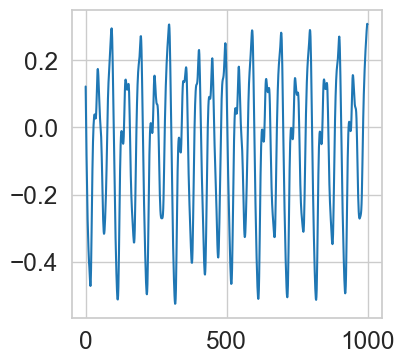

In [17]:
data = np.loadtxt('MackeyGlass.txt')
plt.figure(figsize=(4,4))
plt.plot(data[:1000])

In [18]:
def evaluate(critical_coupling=np.e, p=1):
    #critical_coupling = 2.7
    graph_nx = nx.erdos_renyi_graph(n=NODE, p=p, seed=42)
    graph = nx.to_numpy_array(graph_nx)
    hist = []
    

    critical_model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=10.01, n_nodes=len(graph), natfreqs=natfreqs)
    act_mat = critical_model.run(adj_mat=graph, angles_vec = init_phase)

    ResSize = 3500
    push = 500
    trainLen = ResSize-push
    x = np.linspace(0, 1000,10000)
    #data = np.sin(x)
    input_data = data.reshape(-1,1)
    trainData = input_data[push+1:push+trainLen+1,:]

    input_interval = 10
    sample_interval=10*input_interval

    # Now we are ready to perturb data
    reservoir = []

    act_mat_hist = []

    synced_phases = act_mat[:,-1]

    model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=0.01, n_nodes=NODE, natfreqs=natfreqs)
    synced_phases = getNextPhase(matrix=synced_phases, model=model)

    model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=input_interval+0.01, n_nodes=NODE, natfreqs=natfreqs)

    for t in trange(0, ResSize):
        perturbed_phases = getPerturbedPhase(t, input_data=input_data, index=[0], phase=synced_phases)
        act_mat = model.run(adj_mat=graph, angles_vec=perturbed_phases)
        
        reservoir.append(getReservoir(matrix=act_mat, time_interval=sample_interval))
        synced_phases = getLastPhase(matrix=act_mat)

        act_mat_hist.append(act_mat)

    reservoir_T = np.vstack(reservoir)
    trainRes = reservoir_T[push:push+trainLen,:]

    reg = 1e-8  # regularization coefficient
    Wout = ridge_regression(trainRes, trainData, reg)

    testLen = 1000
    testData = input_data[push+trainLen+1:push+trainLen+1+testLen,:]

    target = trainData[-1,:].reshape(-1,1)

    pred = []

    model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=0.01, n_nodes=NODE, natfreqs=natfreqs)
    synced_phases = getNextPhase(matrix=synced_phases, model=model)

    model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=input_interval+0.01, n_nodes=NODE, natfreqs=natfreqs)

    for t in trange(0, testLen):
        for (i,j) in enumerate([0]):
            synced_phases[j] += target[i]
            
        act_mat = model.run(adj_mat=graph, angles_vec = synced_phases)
        act_mat_sampled = act_mat[:, ::sample_interval]
        act_mat_diff = np.diff(act_mat_sampled, n=1, axis=1)
        reservoir_t = act_mat_diff.flatten(order='K')
        pred.append(np.matmul(reservoir_t, Wout))

        synced_phases = getLastPhase(matrix=act_mat)
        target = pred[-1]

    pred = np.vstack(pred)

    RMSE = mean_squared_error(testData, pred)**0.5
    print(RMSE)
    
    #plt.plot(pred)
    return pred, testData, act_mat_hist, RMSE


In [19]:
pred, testData, act_mat_hist, RMSE = evaluate(3, 1)

100%|██████████| 1000/1000 [00:16<00:00, 59.89it/s]


0.2245497321884561


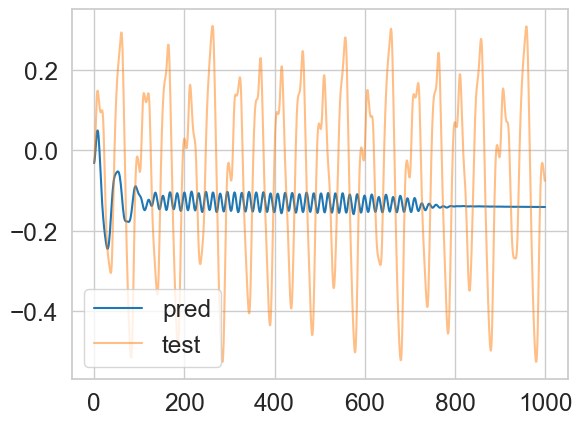

In [20]:
plt.plot(pred, label='pred')
plt.plot(testData, label='test', alpha=0.5)
plt.legend()

In [15]:
act_mat_hist = np.hstack(act_mat_hist)

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

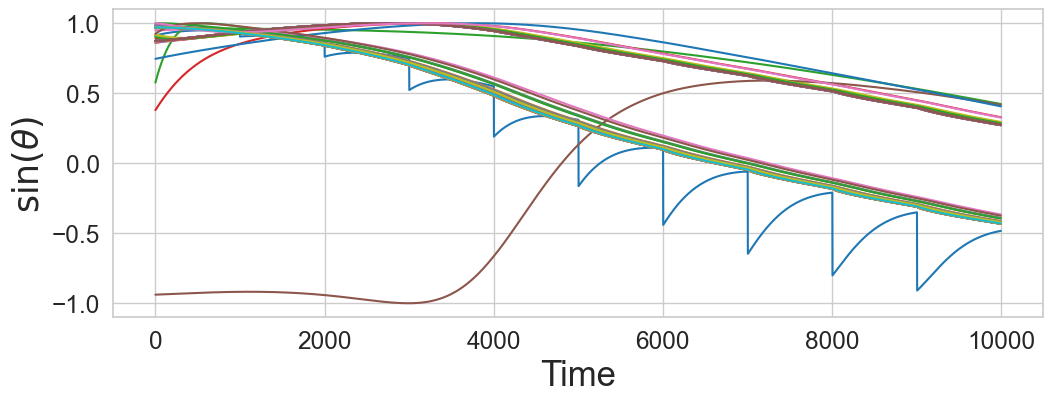

In [16]:
plotting.plot_activity(act_mat_hist[:,:10000])

In [17]:
error_mat = []
for k in np.linspace(2, 4, 11):
    error_mat.append(evaluate(k, 1))

100%|██████████| 1000/1000 [00:02<00:00, 386.51it/s]


0.13551633059682325


100%|██████████| 1000/1000 [00:03<00:00, 271.90it/s]


0.13072173040813287


100%|██████████| 1000/1000 [00:04<00:00, 239.55it/s]


0.15111453874835964


100%|██████████| 1000/1000 [00:11<00:00, 83.55it/s]


0.13103557952792327


100%|██████████| 1000/1000 [00:04<00:00, 201.23it/s]


0.1504795724704843


100%|██████████| 1000/1000 [00:04<00:00, 212.44it/s]


0.13341407624987503


100%|██████████| 1000/1000 [00:03<00:00, 256.99it/s]


0.26621934649274304


100%|██████████| 1000/1000 [00:04<00:00, 248.81it/s]


0.28054227695437484


100%|██████████| 1000/1000 [00:04<00:00, 209.44it/s]


0.2488973900599297


100%|██████████| 1000/1000 [00:04<00:00, 208.21it/s]


0.26450717454052175


100%|██████████| 1000/1000 [00:10<00:00, 93.39it/s]

0.23018647013244084


In [142]:
np.random.seed(42)
init_phase = 2 * np.pi * np.random.random(size=NODE)
natfreqs = np.random.normal(loc = 0, scale = 1, size = NODE)

model = kr.Kuramoto(coupling=1, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
act_mat = model.run(adj_mat=graph, angles_vec = init_phase)

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

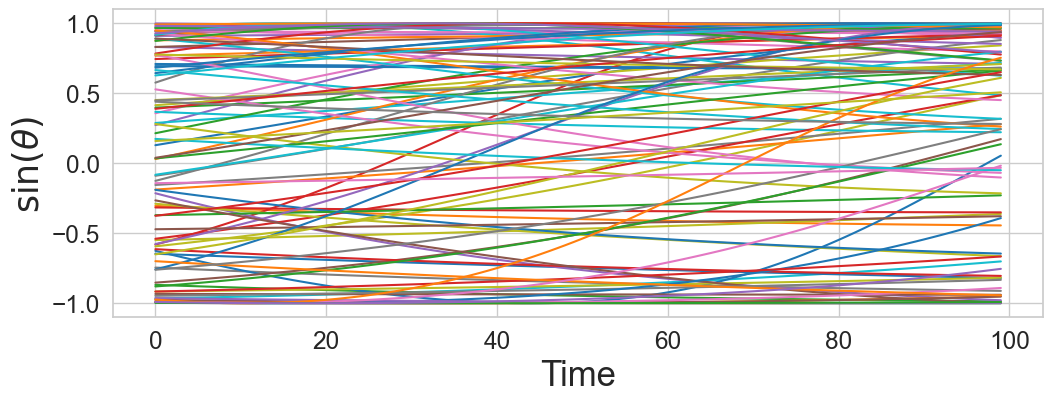

In [128]:
plotting.plot_activity(act_mat)

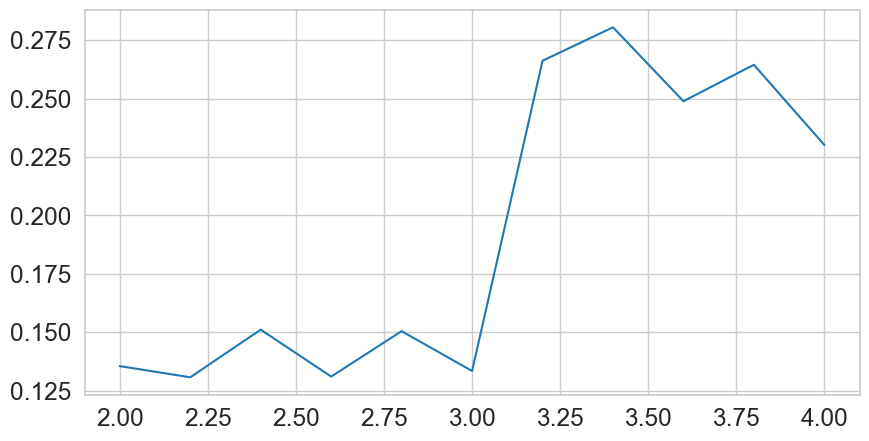

In [18]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(2, 4, 11),error_mat)

In [35]:
adj_mat = nx.to_numpy_array(nx.erdos_renyi_graph(n=100, p=0.1, seed=42))
arr = (adj_mat != 0).sum(axis=0)
np.mean(arr)

9.48

In [39]:
error_mat = []

for mean_degree in np.arange(5, 51, 5):
    p = (2 * mean_degree) / (NODE - 1)
    error_mat.append(evaluate(2.7, p))

100%|██████████| 1000/1000 [00:03<00:00, 251.96it/s]


0.2666267296188687


100%|██████████| 1000/1000 [00:03<00:00, 280.37it/s]


0.3410099846489948


100%|██████████| 1000/1000 [00:03<00:00, 269.65it/s]


0.34961653756310396


100%|██████████| 1000/1000 [00:03<00:00, 279.56it/s]


0.3405222678121469


100%|██████████| 1000/1000 [00:03<00:00, 283.71it/s]


0.35180721878121396


100%|██████████| 1000/1000 [00:03<00:00, 282.30it/s]


0.32244045750129025


100%|██████████| 1000/1000 [00:03<00:00, 285.11it/s]


0.3152396035450688


100%|██████████| 1000/1000 [00:03<00:00, 286.86it/s]


0.274569482337455


100%|██████████| 1000/1000 [00:03<00:00, 291.68it/s]


0.2716955634505905


100%|██████████| 1000/1000 [00:03<00:00, 299.12it/s]

0.21012482452612435


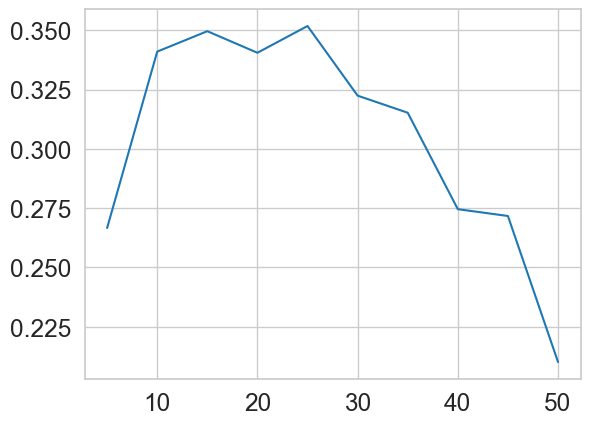

In [40]:
plt.plot(np.arange(5, 51, 5), error_mat)